This notebook file includes the application of pix2pix network (Isola et al. 2017). Instead of predicting the labels, this implementation predicts the scanned images given the label images.
The workflow contains the following:
- Mounting of google drive (the training data stored there)
- Importing necessary packages (assuming the are installed already)
- Training pix2pix network on the training data, (leaving 300 for validation)
- Exporting the results in order of: scanned image (input), labels image (ground truth) and prediction

In [ ]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)
#mount your google drive for this notebook, it will ask for authorization
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
import os
os.chdir('/content/gdrive/My Drive/dl_final3')
!ls

TensorFlow 1.x selected.
1.15.2
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/
dl_final_project_1.ipynb	      my_gen_768_new.json
dl_final_project_2.ipynb	      my_gen_768_old_full_data.h5
dl_final_project_2_old.ipynb	      my_gen_768_old_full_data.json
dl_final_project_2_old_touched.ipynb  outs
in				      outs3
labels_2			      outs_new
my_gen_768_new.h5		      outs_reverse


In [ ]:
#!unzip -q high_reso.zip
#!ls

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-_7koyrpj
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-_7koyrpj
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=d6994e65ecb4b0d321a00bf41c0718b89e9e26bb45567492b8d99b616bcb5f34
  Stored in directory: /tmp/pip-ephem-wheel-cache-9n8zoyjt/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
### Visualize the data ###
# https://github.com/eriklindernoren/Keras-GAN/blob/master/pix2pix/pix2pix.py
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import io
%matplotlib inline
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split

from __future__ import print_function, division
import scipy
from keras.datasets import mnist
from keras.utils import to_categorical
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
#from data_loader import DataLoader

Using TensorFlow backend.


In [ ]:
ids_x_data = next(os.walk("in"))[2]
ids_y_data = next(os.walk("labels_2"))[2]
print(len(ids_x_data))
print(len(ids_y_data))

2803
2803


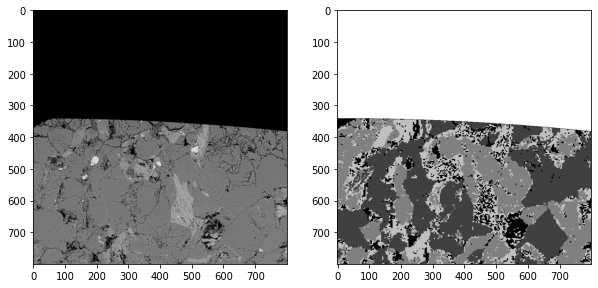

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
im_in = skimage.img_as_ubyte(io.imread('in/img1_Q1_r0_c0.png'))
plt.imshow(im_in,"gray")
plt.subplot(1,2,2)
im_out = skimage.img_as_ubyte(io.imread('labels_2/img1_Q1_r0_c0.png'))
plt.imshow(im_out,"gray")

In [ ]:
print("im in shape",im_in.shape)
print("im out shape",im_out.shape)

im in shape (800, 800)
im out shape (800, 800)


In [ ]:
class Pix2Pix():
    def __init__(self):
        # Input shape
        self.reso = 768
        self.img_rows = self.reso
        self.img_cols = self.reso
        self.channels = 1
        self.classes = 5
        self.input_shape = (self.img_rows, self.img_cols, self.channels)
        self.output_shape = (self.img_rows, self.img_cols, self.channels)
        
        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)
        # Number of filters in the first layer of G and D
        self.gf = 32 #64 each
        self.df = 32
        optimizer = Adam(0.0002, 0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

        #-------------------------------------------
        # Construct Computational Graph of Generator
        #-------------------------------------------
        # Build the generator
        self.generator = self.build_generator()
        # Input images and their conditioning images
        img_A = Input(shape=self.output_shape)
        img_B = Input(shape=self.input_shape)
        # By conditioning on B generate a fake version of A
        fake_A = self.generator(img_B)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([fake_A, img_B])
        self.combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
        self.combined.compile(loss=['mse', 'mae'], loss_weights=[1, 100], optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.input_shape)
        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)
        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(1, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)
        #output_img2 = Conv2D(self.channels, kernel_size=1, strides=1, padding='same', activation='tanh')(output_img)
        #emre mode
        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_B = Input(shape=self.output_shape)
        img_A = Input(shape=self.input_shape)
        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])
        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)
        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)
        return Model([img_A, img_B], validity)

    def train(self, epochs, batch_size=1, sample_interval=50):
        start_time = datetime.datetime.now()
        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i in range(len(ids_x_data)-300): #last 300 for test
            #for batch_i in range(X_train.shape[0]):             #for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
                imgs_A = img_to_array(load_img("in/"+ids_x_data[batch_i], color_mode="grayscale", target_size=(self.reso, self.reso), interpolation='bilinear'))
                imgs_A = imgs_A/255.0
                imgs_A = np.resize(imgs_A, [1,self.reso,self.reso,1])
                imgs_B = img_to_array(load_img("labels_2/"+ids_x_data[batch_i], color_mode="grayscale", target_size=(self.reso, self.reso), interpolation='nearest'))
                imgs_B = np.round(imgs_B/64)
                imgs_B = np.resize(imgs_B, [1,self.reso,self.reso,1])

                # ---------------------
                #  Train Discriminator
                # ---------------------
                # Condition on B and generate a translated version
                fake_A = self.generator.predict(imgs_B)
                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = self.discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                # -----------------
                #  Train Generator
                # -----------------
                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])
                elapsed_time = datetime.datetime.now() - start_time
                # Plot the progress
                if batch_i % sample_interval == 0:
                  print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch+1, epochs,
                                                                        batch_i, len(ids_x_data)-300, #batch_i, self.data_loader.n_batches,
                                                                        d_loss[0], 100*d_loss[1], g_loss[0], elapsed_time))

                # #If at save interval => save generated image samples
                #if batch_i % sample_interval == 0:
                #    self.sample_images(epoch, batch_i) ##this function is moved to the very bottom, not necessary for the time being.

In [29]:
gan = Pix2Pix()
gan.train(epochs=25, batch_size=1, sample_interval=500)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 1/25] [Batch 0/2503] [D loss: 1.994185, acc:  26%] [G loss: 61.666981] time: 0:00:21.013768
[Epoch 1/25] [Batch 500/2503] [D loss: 0.266125, acc:  49%] [G loss: 9.293638] time: 0:02:05.147060
[Epoch 1/25] [Batch 1000/2503] [D loss: 0.262957, acc:  41%] [G loss: 8.837950] time: 0:03:46.346613
[Epoch 1/25] [Batch 1500/2503] [D loss: 0.231932, acc:  51%] [G loss: 6.122702] time: 0:05:27.793417
[Epoch 1/25] [Batch 2000/2503] [D loss: 0.122269, acc:  92%] [G loss: 10.575846] time: 0:07:08.752750
[Epoch 1/25] [Batch 2500/2503] [D loss: 0.055924, acc:  97%] [G loss: 7.284136] time: 0:08:49.300220
[Epoch 2/25] [Batch 0/2503] [D loss: 0.299012, acc:  52%] [G loss: 5.076559] time: 0:08:49.915064
[Epoch 2/25] [Batch 500/2503] [D loss: 0.087199, acc:  92%] [G loss: 5.169736] time: 0:10:30.521756
[Epoch 2/25] [Batch 1000/2503] [D loss: 0.367376, acc:  34%] [G loss: 8.664223] time: 0:12:11.088625
[Epoch 2/25] [Batch 1500/2503] [D loss: 0.050955, acc:  97%] [G loss: 7.837891] time: 0:13:51.337

In [30]:
# serialize model to JSON
model_json = gan.generator.to_json()
with open("/content/gdrive/My Drive/dl_final3/my_gen_768_reverse.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
gan.generator.save_weights("/content/gdrive/My Drive/dl_final3/my_gen_768_reverse.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# without loading images, get accuracy
#%%capture
reso = 768
count = 0
good_x = []
good_y = []
good_p = []
plt.ioff()
for n, id_x, id_y in zip(range(len(ids_x_data)-300,len(ids_x_data)), ids_x_data, ids_y_data):
    x_img = img_to_array(load_img("in/"+id_x, target_size=(reso, reso), interpolation='bilinear', color_mode="grayscale"))
    x_img = x_img/255.0
    x_img = np.reshape(x_img,[1,reso,reso,1])
    y_img = img_to_array(load_img("labels_2/"+id_x, target_size=(reso, reso), interpolation='nearest', color_mode="grayscale")) 
    y_img = np.round(y_img/64).copy()
    #y_img = to_categorical(y_img,num_classes=5)
    y_img = np.reshape(y_img,[1,reso,reso,1])
    predict = gan.generator.predict(y_img)
    #predict = model.predict(y_img)
    plt.figure(figsize=(30,90))
    plt.subplot(131)
    plt.imshow(x_img[0,:,:,0],"gray")
    plt.subplot(132)
    plt.imshow(y_img[0,:,:,0],"gray")
    plt.subplot(133)
    plt.imshow(predict[0,:,:,0],"gray")
    plt.savefig("/content/gdrive/My Drive/dl_final3/outs_reverse/test_"+id_x)
    plt.close()    
    count = count+1

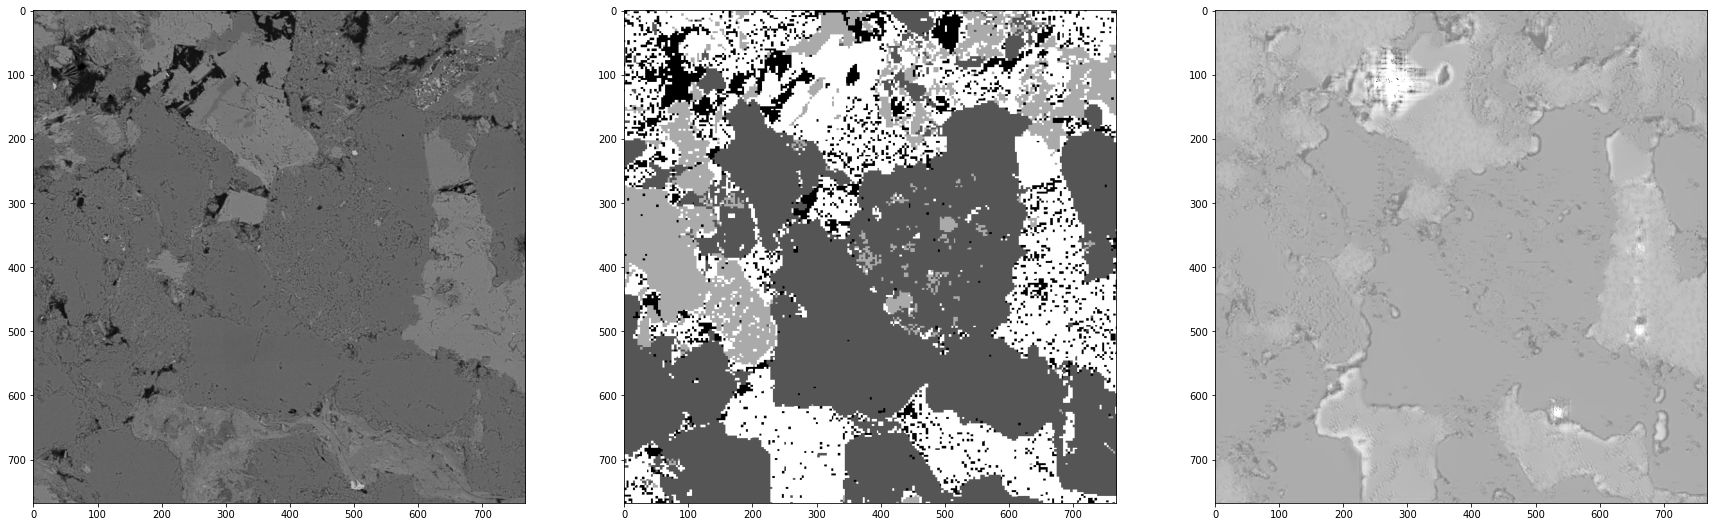

In [34]:
plt.figure(figsize=(30,90))
plt.subplot(131)
plt.imshow(x_img[0,:,:,0],"gray")
plt.subplot(132)
plt.imshow(y_img[0,:,:,0],"gray")
plt.subplot(133)
plt.imshow(predict[0,:,:,0],"gray")

In [35]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jun  5 11:05:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    32W / 250W |   7715MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [36]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!nvidia-smi

In [37]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz


In [38]:
!free -h --si | awk  '/Mem:/{print $2}'

26G


In [ ]:
from keras.models import model_from_json
# load json and create model
json_file = open('/content/gdrive/My Drive/dl_final2/my_gen_768.json', 'r')
model = json_file.read()
json_file.close()
model = model_from_json(model)
# load weights into new model
model.load_weights("/content/gdrive/My Drive/dl_final2/my_gen_768.h5")
print("Loaded model from disk")

In [ ]:
"""
X_test = np.zeros((300, reso, reso, 1), dtype=np.float32)
y_test = np.zeros((300, reso, reso, 5), dtype=np.float32)
# Load images
count = 0
for n, id_x, id_y in zip(range(len(ids_x_data)-300,len(ids_x_data)), ids_x_data, ids_y_data):
    x_img = img_to_array(load_img("in/"+id_x, target_size=(reso, reso), interpolation='bilinear', color_mode="grayscale"))
    y_img = img_to_array(load_img("labels_2/"+id_x, target_size=(reso, reso), interpolation='nearest', color_mode="grayscale")) 
    X_test[count] = x_img/255.0
    a = np.round(y_img/64).copy()
    y_test[count] = to_categorical(a,num_classes=5)
    count = count+1
"""    

In [ ]:
"""
    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 3, 3

        imgs_A = X_train[128]
        imgs_B = y_train[128]
        imgs_A = np.resize(imgs_A, [1,256,256,3])
        imgs_B = np.resize(imgs_B, [1,256,256,3])
        imgs_A, imgs_B = self.data_loader.load_data(batch_size=3, is_testing=True)
        fake_A = self.generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        titles = ['Condition', 'Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i,j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.close()

"""

In [ ]:
#X_data = np.zeros((len(ids_x_data)-minus, 256, 256, 3), dtype=np.float32)
#y_data = np.zeros((len(ids_y_data)-minus, 256, 256, 3), dtype=np.float32)
# Load images
#for n, id_x, id_y in zip(range(len(ids_x_data)-minus), ids_x_data, ids_y_data):
#    x_img = img_to_array(load_img("in_final/"+id_x, target_size=(256, 256), interpolation='bilinear'))
#    y_img = img_to_array(load_img("out_final/"+id_y, target_size=(256, 256), interpolation='nearest')) 
#    X_data[n] = x_img/255.0
#    y_data[n] = y_img/255.0
#plt.imshow(y_data[968])
#X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, shuffle=True)
#del X_data, y_data
#print(X_train.shape)